## Stock Performance Tracker


## Setup


In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils, draw_utils, process_utils, const


In [11]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")


In [12]:
log_df, cf_df = process_utils.prepare_log_df_cf_df()


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


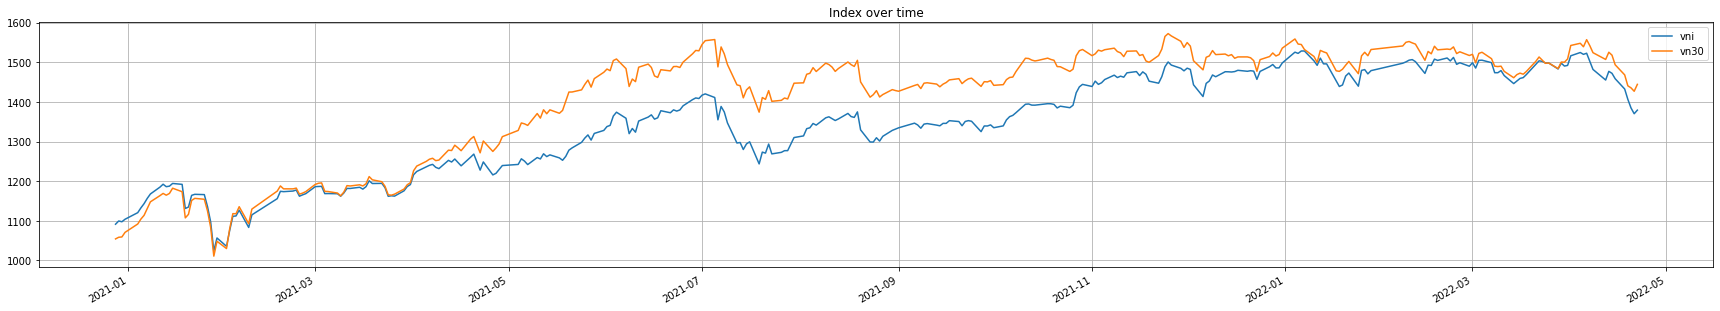

In [13]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in const.INDEX_NAME_L
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


## [Chart] NAV stack


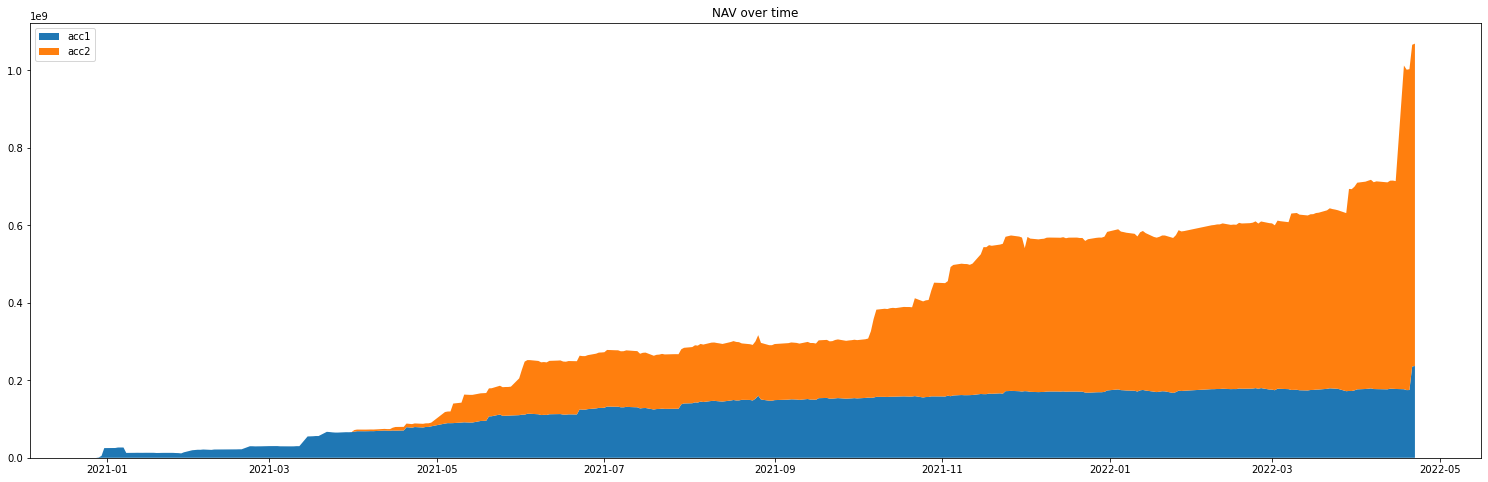

In [14]:
y_list = [log_df[acc_name] for acc_name in const.ACC_NAME_L]

draw_utils.plot_nav_stackplot(
    x=log_df.index,  # type: ignore
    y=y_list,
    labels=const.ACC_NAME_L,
)


## [Chart] NAV pie


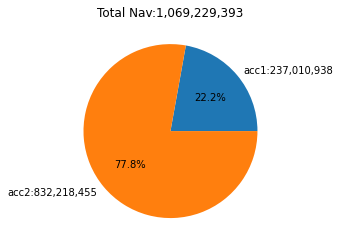

In [15]:
nav_l = [log_df[acc_name].iloc[-1] for acc_name in const.ACC_NAME_L]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(const.ACC_NAME_L, nav_l)]
draw_utils.plot_nav_pie(nav_l, label_l=label_l)


## [Chart] Profit


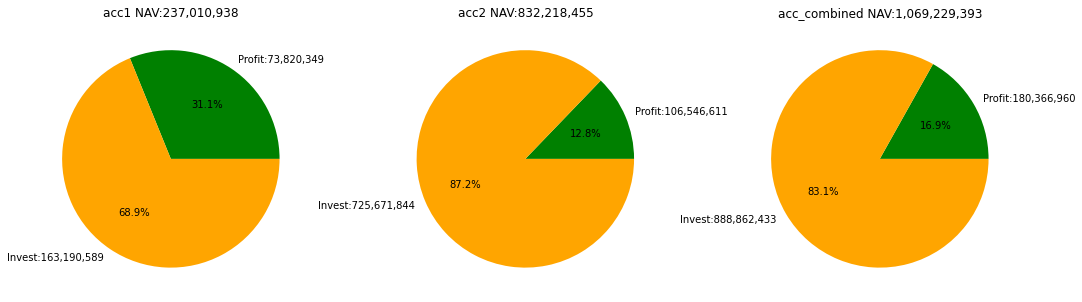

In [16]:
profit_invest_list: list[tuple[str, float, float]] = []
for name in const.ALL_ACC_NAME_L:
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest
    profit_invest_list.append((name, profit, invest))

draw_utils.plot_profit_invest_pies(profit_invest_list)


## [Chart] Diff percent


### Histogram


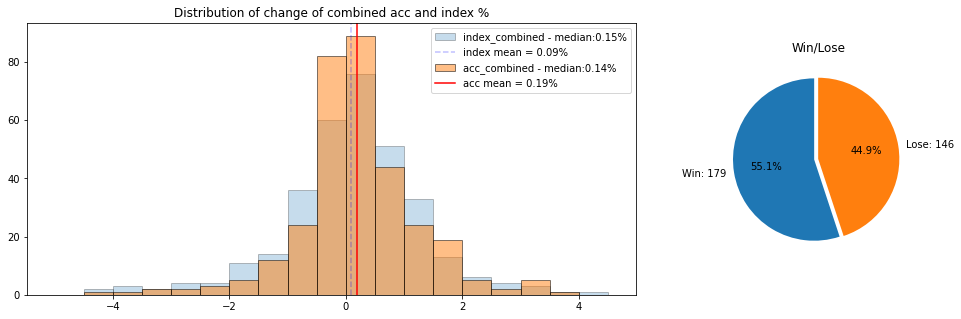

In [17]:
draw_utils.plot_daily_diff_p_distribution(
    log_df,
    acc_name=const.ACC_COMBINED_NAME,
    index_name=const.INDEX_COMBINED_NAME,
)


## [Chart] Daily


### Latest growth


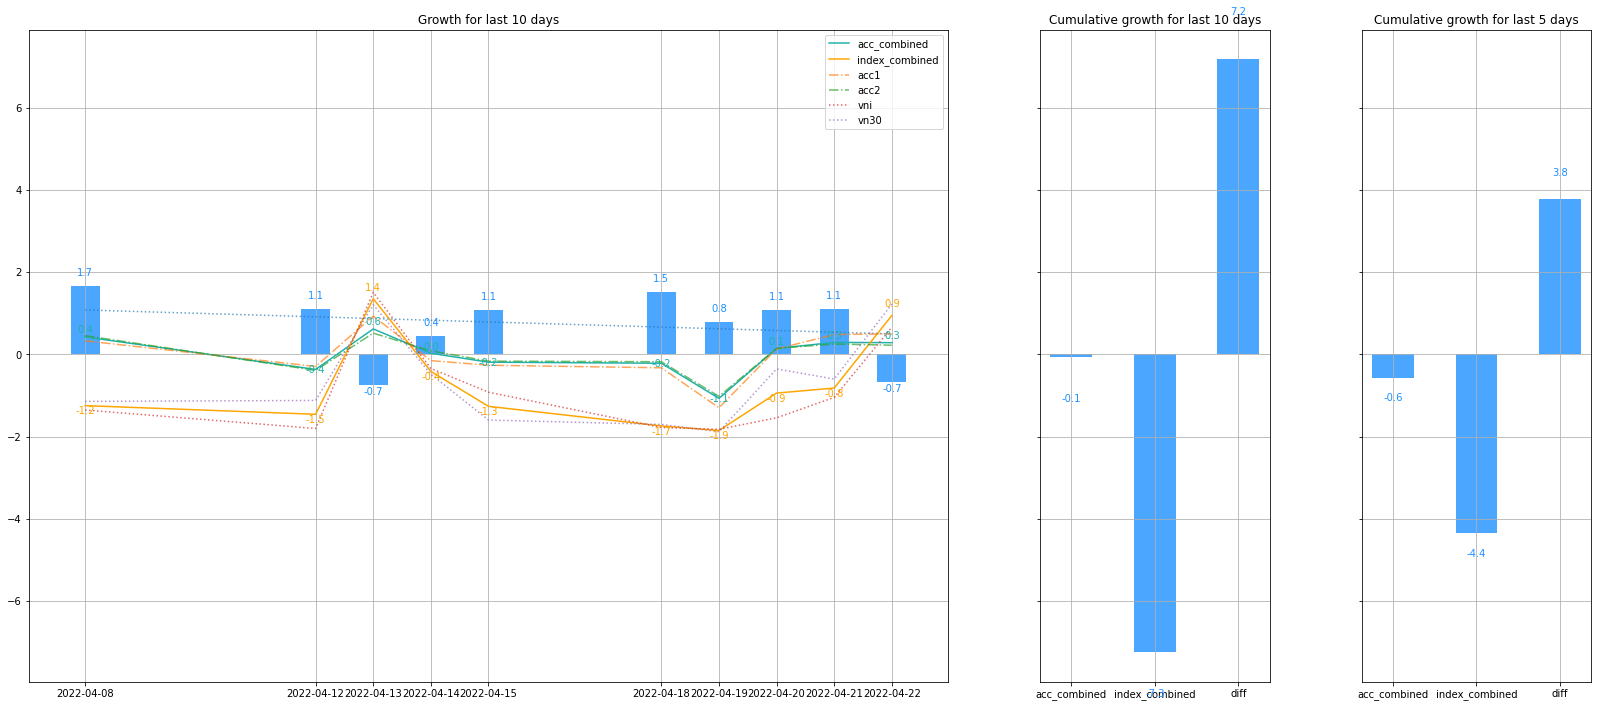

In [19]:
draw_utils.plot_recent_growth(
    log_df,
    num_days=10,
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)


In [20]:
# recent_daily_df  # type: ignore


### XIRR


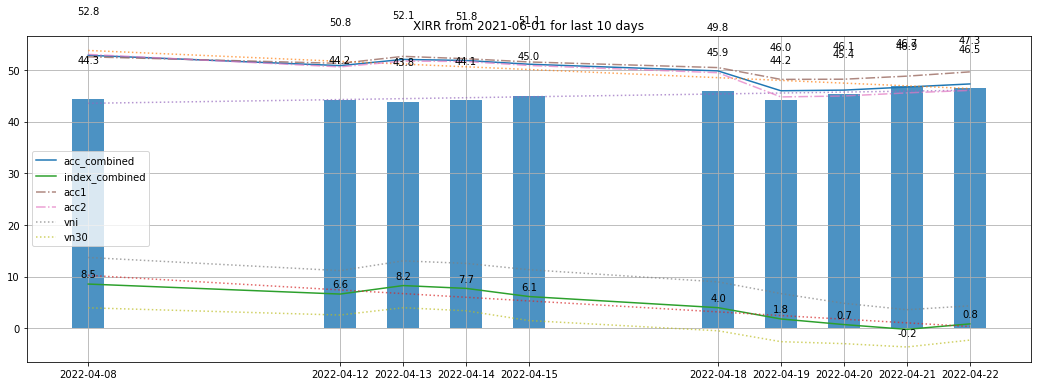

In [21]:
draw_utils.plot_recent_xirr(
    log_df=log_df,
    cf_df=cf_df,
    num_days=10,
    anchor_date='2021-06-01',
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)

In [22]:
# xirr_df  # type: ignore


### Income


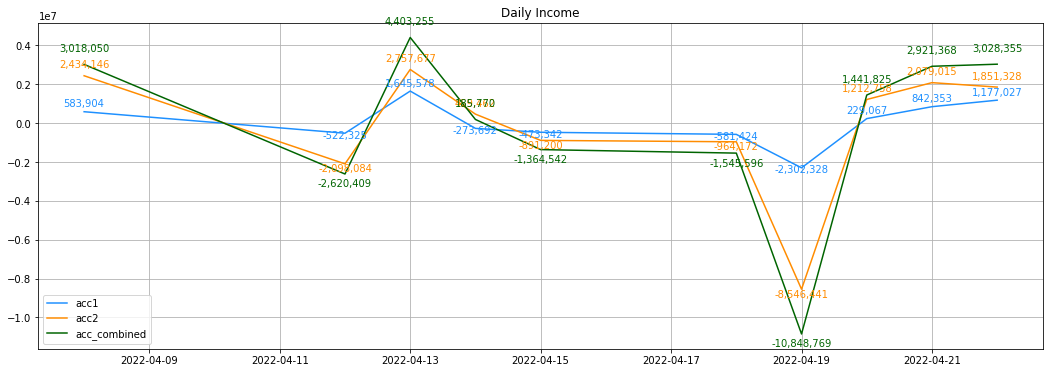

In [23]:
draw_utils.plot_recent_income(
    daily_df=log_df,
    num_days=10,
    name_l=const.ALL_ACC_NAME_L,
    color_l=const.COLOR_LIST[: len(const.ALL_ACC_NAME_L)],
)


In [24]:
# recent_daily_df  # type: ignore


### Growth time series


In [25]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df: pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L:
        # calculate growth using cumulative product since anchor date

        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)

    for name in const.ALL_ACC_NAME_L:
        df[f"{name}_xirr"] = (
            filtered_log_df.index.to_series().apply(
                lambda date_idx: utils.calc_cashflow_xirr(
                    cf_df,
                    log_df,
                    anchor_date,
                    date_idx,
                    name,
                    const.ALL_ACC_NAME_L,
                )
            )
            * 100
        )
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0

    for name in const.ALL_INDEX_NAME_L:
        df[f"{name}_xirr"] = (
            filtered_log_df.index.to_series().apply(
                lambda date_idx: utils.calc_index_xirr(
                    log_df,
                    anchor_date,
                    date_idx,
                    name,
                )
            )
            * 100
        )
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0

    return df


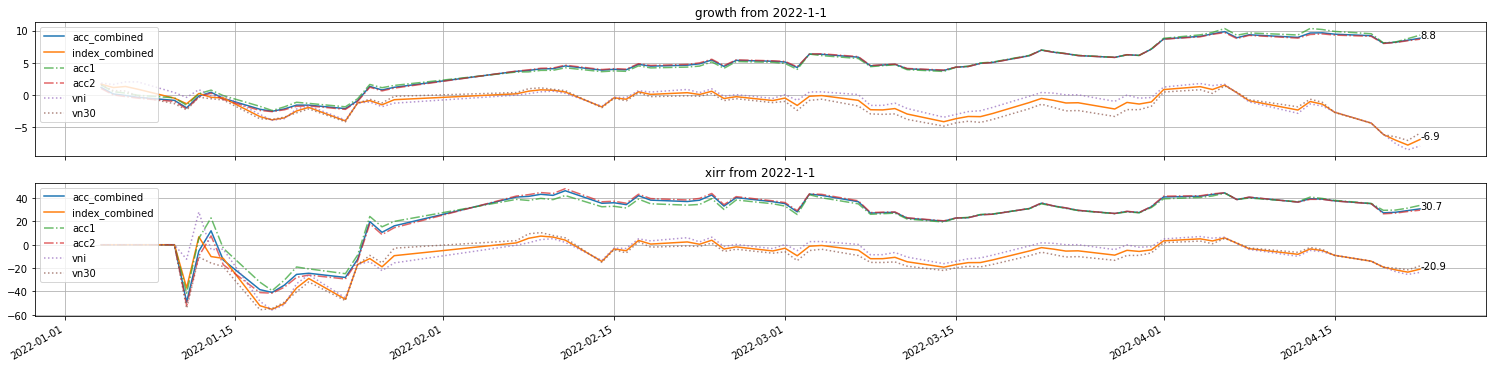

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2022-1-1"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, growth_xirr_df: pd.DataFrame, type: str):
    # Normalize growth from 0
    if type == "growth":
        growth_xirr_df = growth_xirr_df.applymap(lambda e: e - 100)

    for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            fmt="-",
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in const.ACC_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt="-.",
            alpha=0.7,
            label=single_name,
        )

    for single_name in const.INDEX_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt=":",
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()


_plot_overall_growth_xirr(ax1, growth_xirr_df, "growth")
_plot_overall_growth_xirr(ax2, growth_xirr_df, "xirr")

plt.show()


In [27]:
# growth_xirr_df  # type: ignore


## [Process] Add period info


In [28]:
log_df = process_utils.add_period_cols(log_df)
# log_df.tail()


## [Chart] Weekly


In [29]:
weekly_df = process_utils.get_period_df(
    period_symbol="W",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Not enough space to plot every week
weekly_df = process_utils.filter_latest_x_rows(df=weekly_df, row_num=20)  # type: ignore


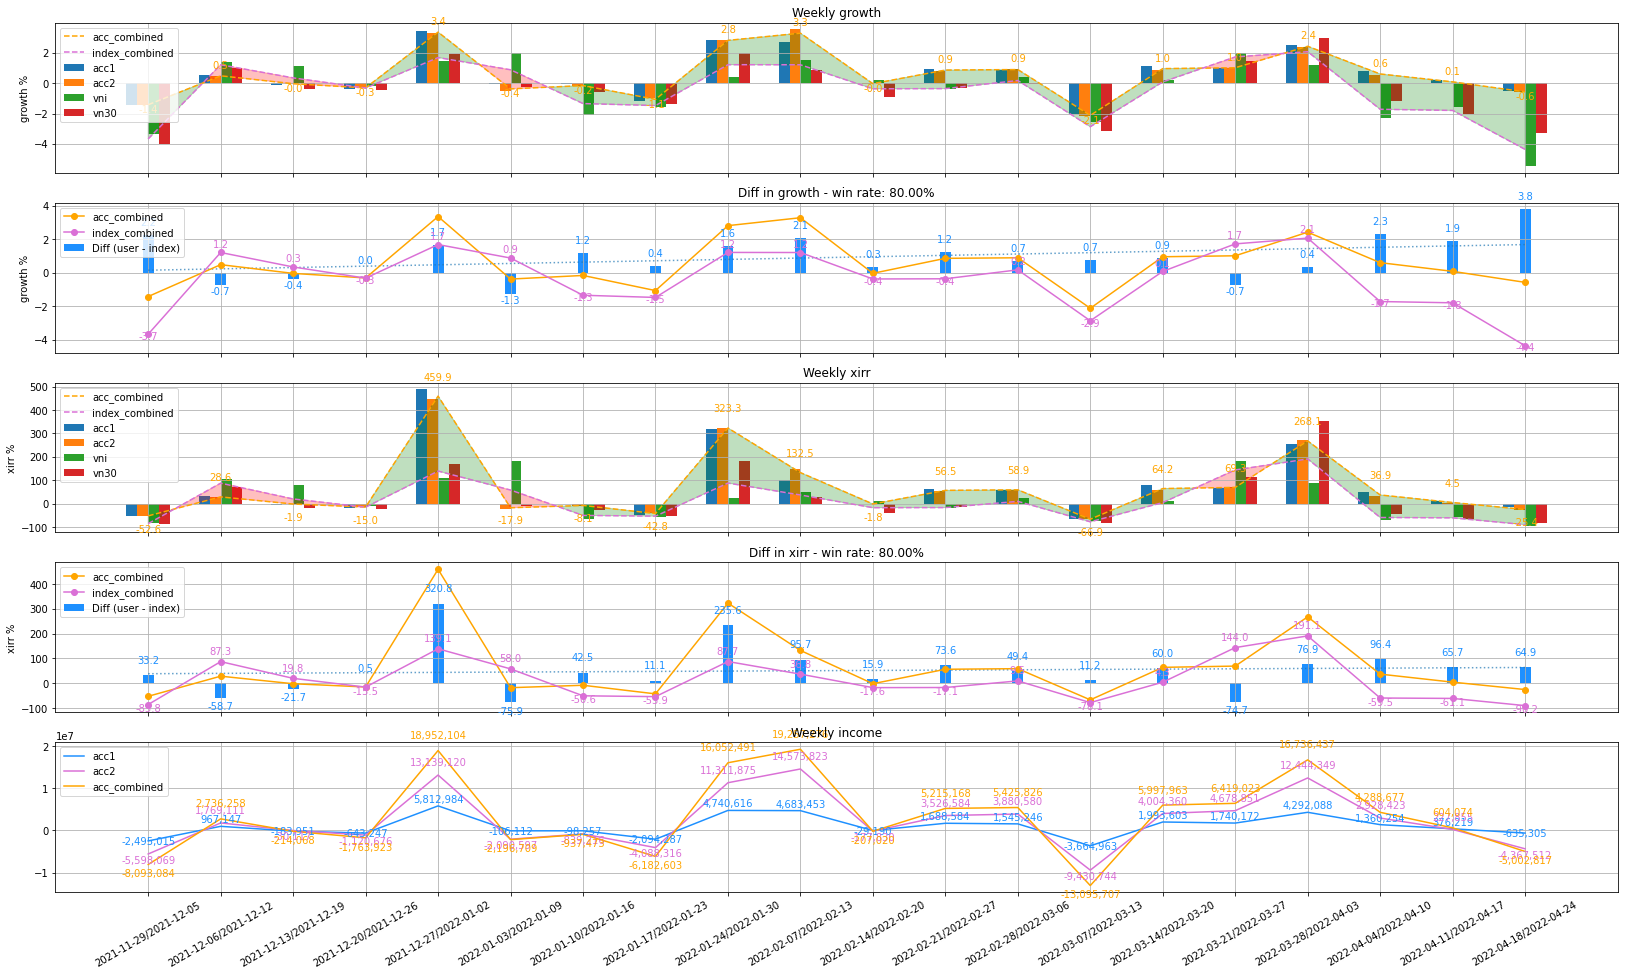

In [30]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=weekly_df,
    period_name="Weekly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [31]:
# weekly_df.tail()


## [Chart] Monthly


In [32]:
monthly_df = process_utils.get_period_df(
    period_symbol="M",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)


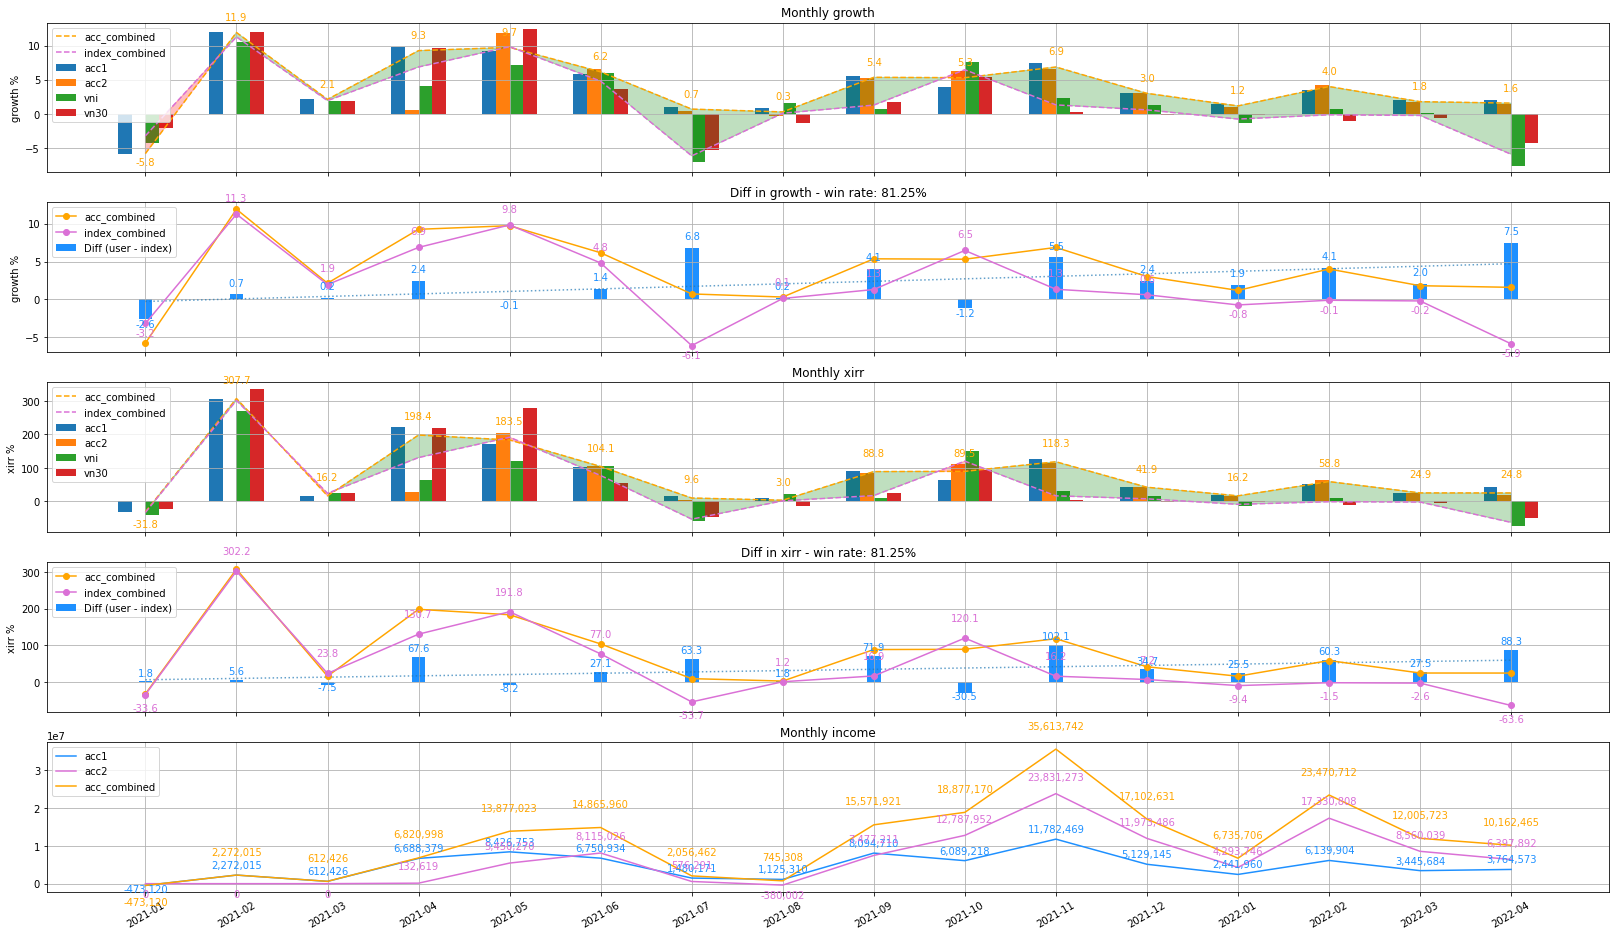

In [33]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=monthly_df,
    period_name="Monthly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [34]:
# monthly_df # type: ignore


## Quaterly


In [35]:
quaterly_df = process_utils.get_period_df(
    period_symbol="Q",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020Q4
quaterly_df.drop(["2020Q4"], inplace=True)


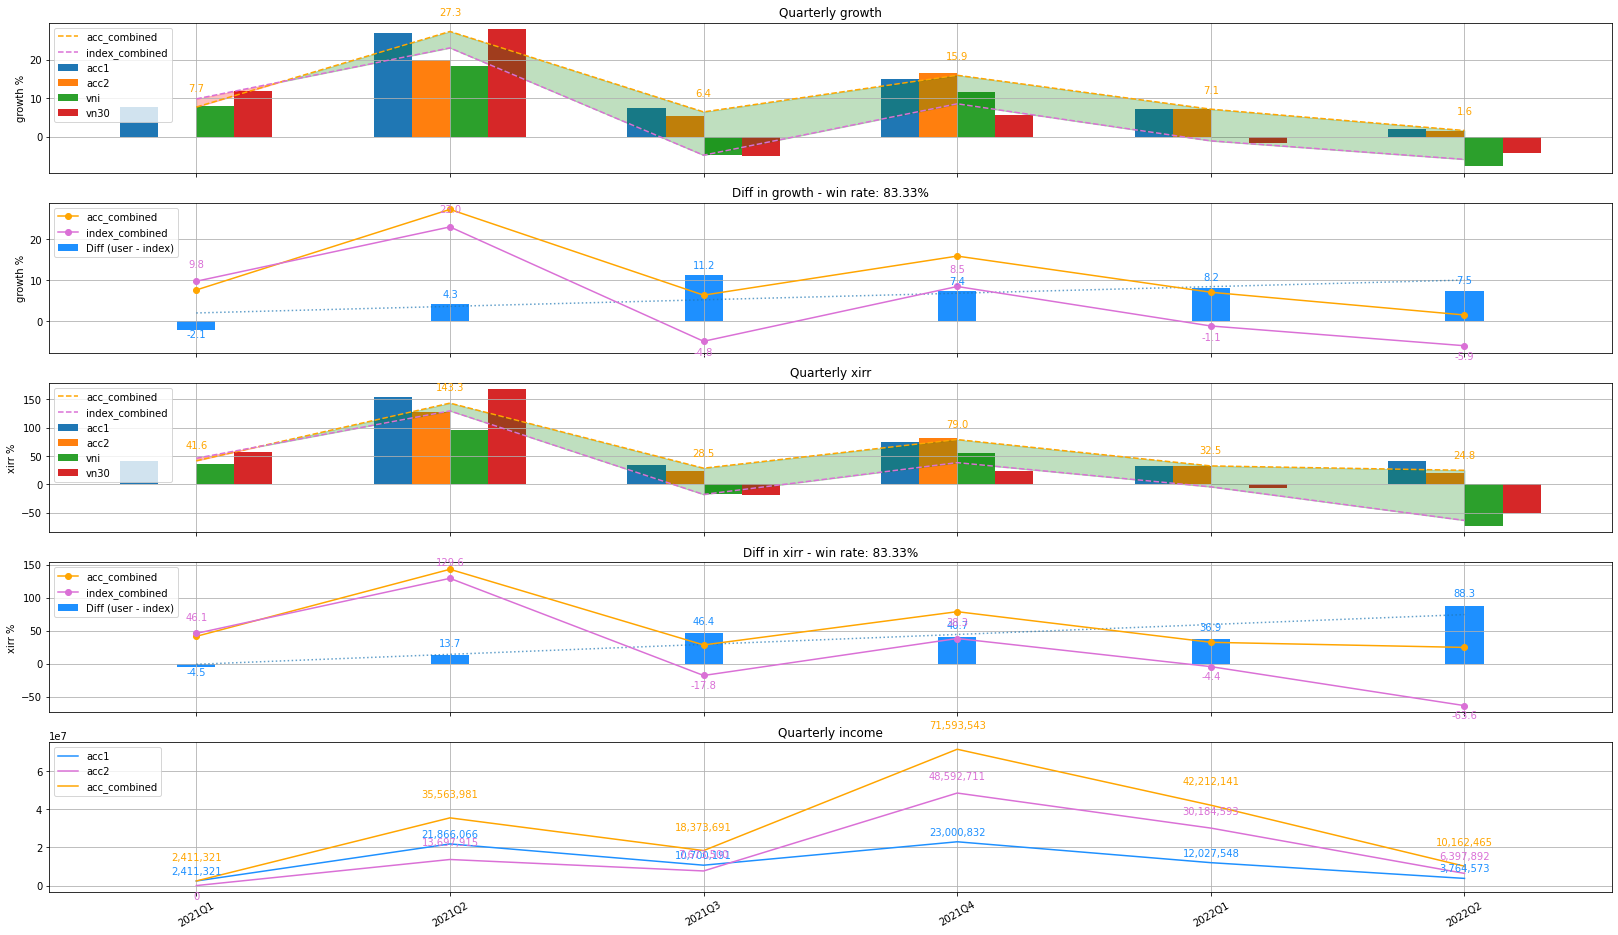

In [36]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=quaterly_df,
    period_name="Quarterly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [37]:
# quaterly_df  # type: ignore


## Yearly


In [38]:
yearly_df = process_utils.get_period_df(
    period_symbol="Y",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020
yearly_df.drop(["2020"], inplace=True)


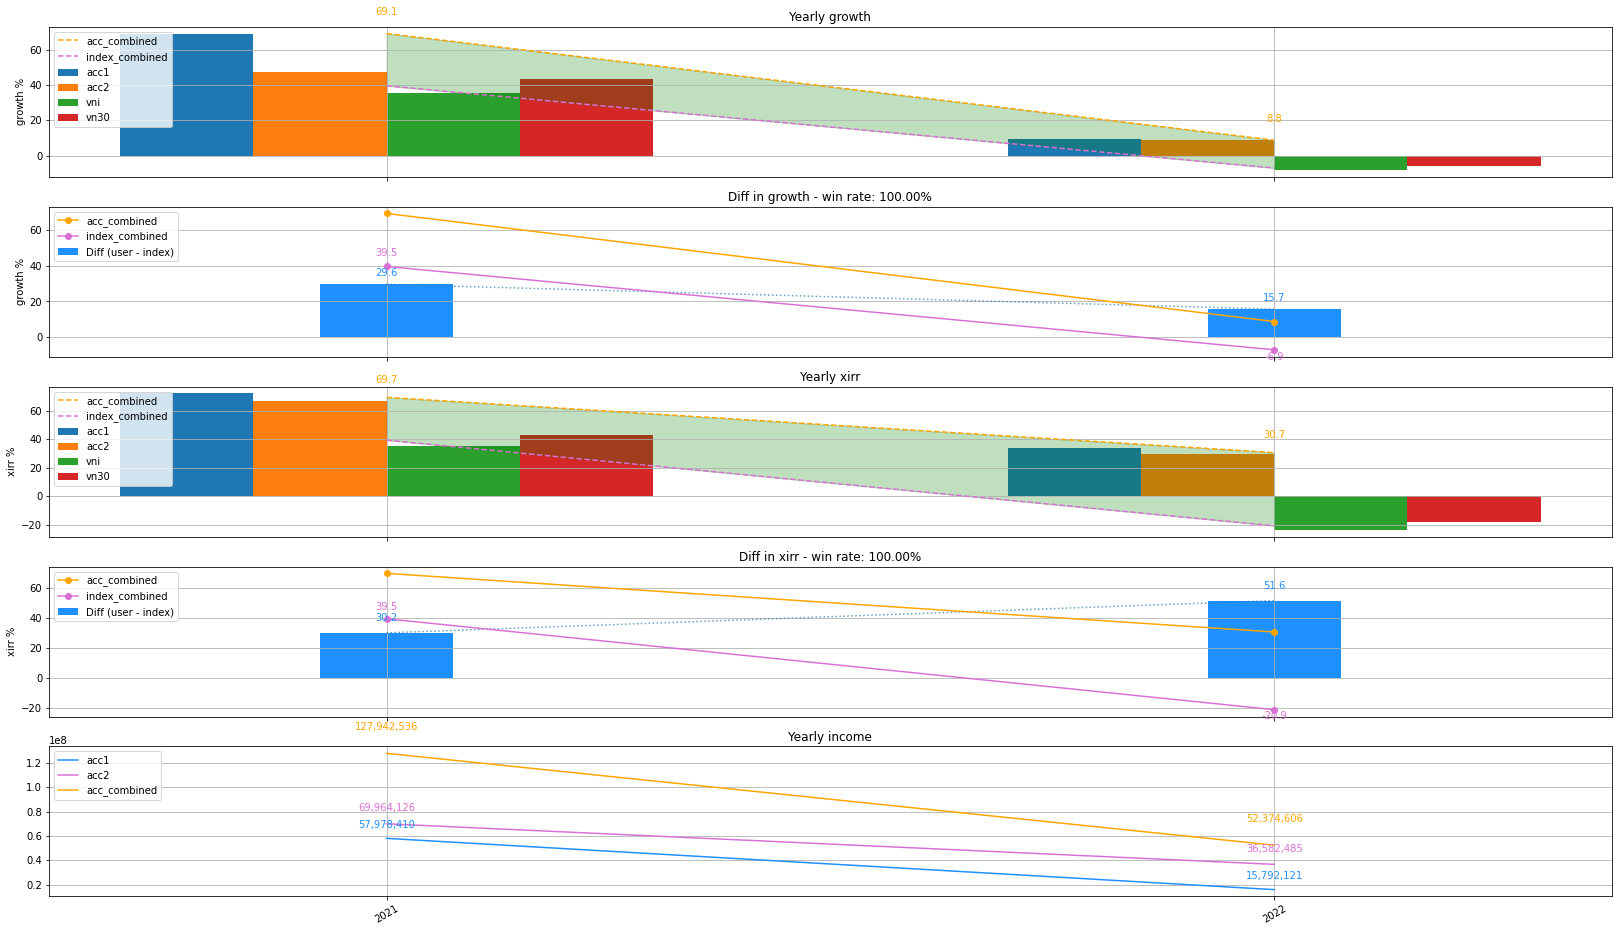

In [39]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=yearly_df,
    period_name="Yearly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [40]:
# yearly_df # noqa
